In [1]:
import torch
import matplotlib.pyplot as plt

import utils.datasets as datasets
import utils.sde_lib as sdes
from utils.models import MLP
from utils.misc import dotdict, batch_matrix_product

torch.set_printoptions(precision=3,sci_mode=False)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 1000
# covs = torch.tensor([[[3., -1.],[-1., 2.]], [[3., 1.8],[1.8, 2.]], [[3., -1.],[-1., 2.]]], device=device)
# means = torch.tensor([[0,3.], [10,5.], [-6.,0]],device=device)
# weights = torch.ones(means.shape[0],device=device)/means.shape[0]
# gmm = GMM(weights,means,covs)
dataset = datasets.get_dataset(dotdict({'dataset' : 'spiral'}))
data = dataset.sample(5).to(device=device)

sde = sdes.LinearSchrodingerBridge(2,device)
model = MLP(2,False).to(device=device)

eps = sde.delta
times = (torch.rand((data.shape[0]),device=data.device) * (1-eps) + eps) * sde.T()
shaped_t = times.reshape(-1,1,1,1) if len(data.shape) > 2 else times.reshape(-1,1)
mean, L, invL = sde.marginal_prob(data,shaped_t)
noise = torch.randn_like(mean,device=data.device)
perturbed_data = mean + torch.bmm(L, noise.unsqueeze(-1)).squeeze(-1)
flatten_error = ((torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1) + model(perturbed_data,times))**2).view(data.shape[0],-1)


std = (1-torch.exp(-sde.beta_int(shaped_t)))**.5

# print(times)
# print((std).cpu().numpy())
# print(L[:,0,0].cpu().numpy())

# print(L)
# print(invL.mT)

# print(perturbed_data)
# print(torch.exp(-sde.beta_int(shaped_t)/2) * data + noise * std)

# print(torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1))
# print(noise / std)

# plt.scatter(data[:,0], data[:,1])
# plt.show()


print(-.5 * sde.beta(shaped_t) * perturbed_data)
print(-.5 * sde.beta(shaped_t) * batch_matrix_product(sde.A(shaped_t),perturbed_data))
print(sde.drift(perturbed_data,shaped_t))


tensor([[ 0.640,  0.384],
        [ 0.872, -0.143]], grad_fn=<ViewBackward0>)
tensor([[ 25662.605,  14242.535],
        [   -19.172,    -18.924],
        [   -16.458,    -23.058],
        [     2.911,     -1.796],
        [   300.506,    165.546]], device='cuda:0')
tensor([[-75813.070, -42109.562],
        [    77.456,     18.439],
        [    83.614,      5.121],
        [    -0.026,    -10.137],
        [  -884.664,   -495.035]], device='cuda:0')
tensor([[-75813.070, -42109.562],
        [    77.456,     18.439],
        [    83.614,      5.121],
        [    -0.026,    -10.137],
        [  -884.664,   -495.035]], device='cuda:0')


In [3]:
t = shaped_t
int_mat = sde.int_beta_ds(t)
print(int_mat)
dim = int_mat.shape[-1]
C_H_power = torch.zeros((t.shape[0], 2 * dim, 2 * dim),device=int_mat.device)
C_H_pair = torch.zeros_like(C_H_power)
C_H_power[:,:dim, :dim] = -.5 * int_mat
C_H_power[:,-dim:, -dim:] = .5 * int_mat
C_H_power[:, :dim, dim:] = sde.beta_int(t).view(-1,1,1) * torch.eye(dim,device=int_mat.device).unsqueeze(0).expand(t.shape[0],-1,-1)


print(C_H_power)
C_H_pair = torch.linalg.matrix_exp(C_H_power)
initial_cond = torch.cat((torch.zeros((dim,dim), device=int_mat.device), torch.eye(dim,device=int_mat.device)), dim=0)
C_H = torch.einsum('tij,jk->tik', C_H_pair, initial_cond)
C = C_H[:, : dim, :]
H = C_H[:, dim: , :]
cov = torch.einsum('tij,tjk->tik', C, torch.linalg.inv(H))
L = torch.linalg.cholesky(cov)
invL = torch.linalg.inv(L.mH)
print(C_H_pair)

tensor([[[ -6.260, -10.089],
         [-10.089,   6.310]],

        [[ -0.620,  -1.000],
         [ -1.000,   0.625]],

        [[ -0.418,  -0.673],
         [ -0.673,   0.421]],

        [[ -0.256,  -0.413],
         [ -0.413,   0.258]],

        [[ -4.715,  -7.600],
         [ -7.600,   4.753]]], device='cuda:0')
tensor([[[ 3.130,  5.045,  4.025,  0.000],
         [ 5.045, -3.155,  0.000,  4.025],
         [ 0.000,  0.000, -3.130, -5.045],
         [ 0.000,  0.000, -5.045,  3.155]],

        [[ 0.310,  0.500,  0.399,  0.000],
         [ 0.500, -0.313,  0.000,  0.399],
         [ 0.000,  0.000, -0.310, -0.500],
         [ 0.000,  0.000, -0.500,  0.313]],

        [[ 0.209,  0.337,  0.269,  0.000],
         [ 0.337, -0.211,  0.000,  0.269],
         [ 0.000,  0.000, -0.209, -0.337],
         [ 0.000,  0.000, -0.337,  0.211]],

        [[ 0.128,  0.207,  0.165,  0.000],
         [ 0.207, -0.129,  0.000,  0.165],
         [ 0.000,  0.000, -0.128, -0.207],
         [ 0.000,  0.000, -0.207

In [4]:
ts = torch.linspace(.1,sde.T(), 6,device=device).unsqueeze(-1)
cov, L, invL = sde.compute_variance(ts)
print(L)
print(invL)

tensor([[[    0.347,     0.023],
         [    0.023,     0.318]],

        [[    1.526,     0.540],
         [    0.540,     0.854]],

        [[   10.729,     5.635],
         [    5.635,     3.709]],

        [[  198.567,   109.923],
         [  109.923,    61.615]],

        [[ 9604.091,  5330.760],
         [ 5330.760,  2962.556]],

        [[1201874.375, 667148.875],
         [667148.875, 370681.062]]], device='cuda:0')
tensor([[[     2.897,     -0.207],
         [    -0.207,      3.155]],

        [[     0.844,     -0.533],
         [    -0.533,      1.509]],

        [[     0.461,     -0.700],
         [    -0.700,      1.333]],

        [[     0.406,     -0.724],
         [    -0.724,      1.308]],

        [[     0.083,     -0.150],
         [    -0.150,      0.269]],

        [[     0.001,     -0.002],
         [    -0.002,      0.003]]], device='cuda:0')


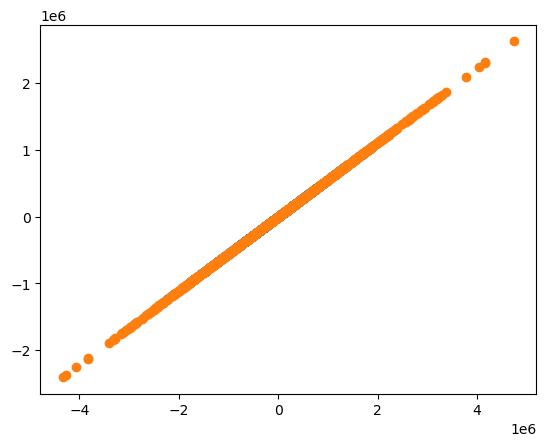

In [5]:
x = torch.randn((1000,2),device=device)
steps = 100
times = torch.linspace(0,sde.T(),steps=steps, device=device)
dt = sde.T()/steps
for i in range(steps):
    ti = times[i].expand(x.shape[0],1)
    x = x + sde.drift(x,ti) * dt + sde.diffusion(x,ti) * torch.randn_like(x) * dt**.5

prior = sde.prior_sampling((1000,2),device)
plt.scatter(x[:,0].cpu().numpy(), x[:,1].cpu().numpy())
plt.scatter(prior[:,0].cpu().numpy(), prior[:,1].cpu().numpy())
# plt.savefig(f'./trajectory/{i}.png')
# plt.close()
plt.show()